Data sourced from Kaggle competition [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview)

In [449]:
# import core libraries

import pandas as pd

pd.options.display.max_rows = 100
pd.options.display.max_colwidth=200

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# import sklearn modules

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve
import scikitplot as skplt

# nlp libraries

import nltk

from textblob import TextBlob
import contractions
import preprocessor as p
import string

p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.SMILEY, p.OPT.MENTION, p.OPT.RESERVED)

In [357]:
# instantiating the train and test sets

train_kaggle = pd.read_csv('data/train.csv')
test_kaggle =  pd.read_csv('data/test.csv')

In [358]:
# combining the train and test sets for the purpose of EDA and Data Cleaning/Feature Engineering

df = pd.concat([train_kaggle, test_kaggle], ignore_index=True)

In [359]:
print("Training Dataframe Shape: {}".format(str(train_kaggle.shape)))
print("Test Dataframe Shape: {}".format(str(test_kaggle.shape)))
print("Combined Dataframe Shape: {}".format(str(df.shape)))

Training Dataframe Shape: (7613, 5)
Test Dataframe Shape: (3263, 4)
Combined Dataframe Shape: (10876, 5)


In [360]:
# example of tweets

df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0


In [361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10876 non-null  int64  
 1   keyword   10789 non-null  object 
 2   location  7238 non-null   object 
 3   text      10876 non-null  object 
 4   target    7613 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 425.0+ KB


In [362]:
# to begin with, let's set the id column as the index

df.set_index('id',inplace=True)

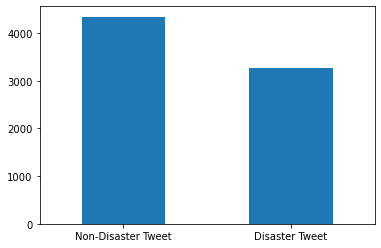

In [363]:
df.target.value_counts().plot.bar()

plt.xticks([0,1], ['Non-Disaster Tweet', 'Disaster Tweet'], rotation=0)

plt.show()

Dataset is slightly imbalanced

In [364]:
df.target.value_counts(normalize='all')

0.0    0.57034
1.0    0.42966
Name: target, dtype: float64

Baseline prediction for this dataset is approx 57%

### Dealing with null values

In [365]:
# null values in the training set

df.isnull().sum()

keyword       87
location    3638
text           0
target      3263
dtype: int64

In [366]:
# creating a new category for the null keyword and location values

df.fillna({'keyword': 'unknown', 'location': 'unknown'},inplace=True)

### Keyword

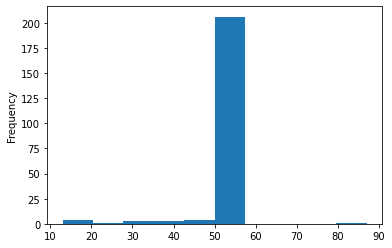

In [367]:
df.keyword.value_counts().plot.hist()

plt.show()

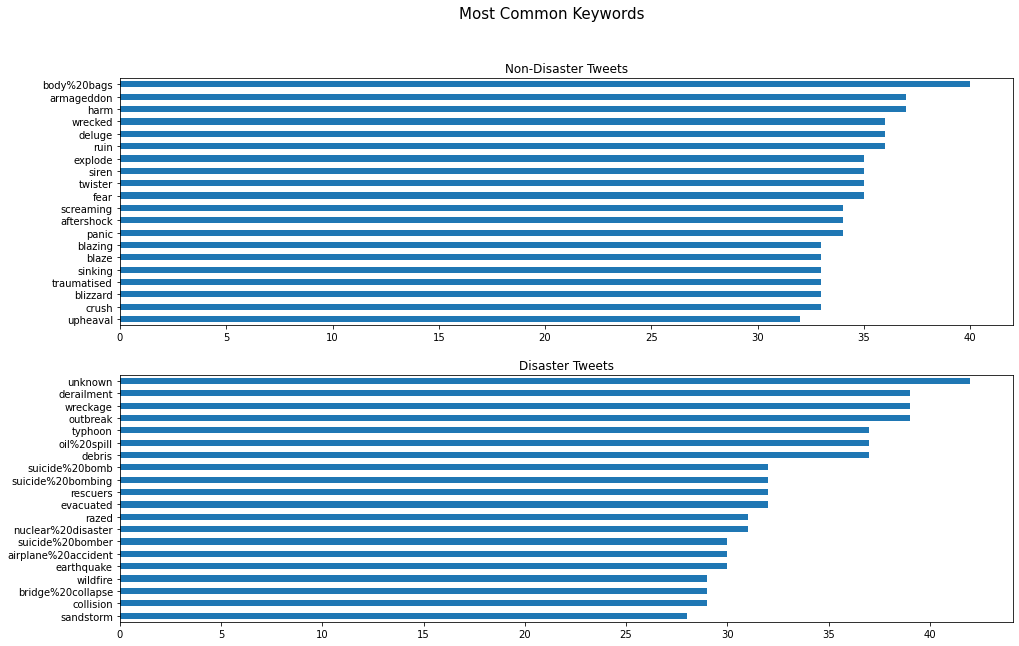

In [368]:
fig,ax = plt.subplots(2,1,figsize=(16,10))

df[df.target==0].keyword.value_counts(ascending=True).tail(20).plot.barh(ax=ax[0])
df[df.target==1].keyword.value_counts(ascending=True).tail(20).plot.barh(ax=ax[1])

ax[0].set_title('Non-Disaster Tweets')
ax[1].set_title('Disaster Tweets')

fig.suptitle('Most Common Keywords', fontsize=15)

plt.show()

In [369]:
df.keyword.unique()

array(['unknown', 'ablaze', 'accident', 'aftershock',
       'airplane%20accident', 'ambulance', 'annihilated', 'annihilation',
       'apocalypse', 'armageddon', 'army', 'arson', 'arsonist', 'attack',
       'attacked', 'avalanche', 'battle', 'bioterror', 'bioterrorism',
       'blaze', 'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard',
       'blood', 'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail'

At the moment, the keyword column is messy. There are different values for variations of the same word. It would make sense to simplify the values in this column.

In [370]:
# cleaning the keyword column

df.replace({'keyword': '%20'}, {'keyword': ' '}, inplace=True, regex=True)

In [371]:
df.keyword.unique().shape

(222,)

In [372]:
# tokenizing the values

df['keyword_clean'] = df.keyword.apply(nltk.word_tokenize)

In [373]:
# part-of-speech tagging the text column

df['keyword_clean'] = df.keyword_clean.apply(nltk.tag.pos_tag)

# instantiating the nltk lemmatizer
wnl = WordNetLemmatizer()

In [374]:
# creating a function to alter the POS tagging so that it is in the right format for the NLTK lemmatizer

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
df['keyword_clean'] = df['keyword_clean'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

In [375]:
# lemmatizing the text column

df['keyword_clean'] = df.keyword_clean.apply(lambda x: ' '.join([wnl.lemmatize(word, tag) for word,tag in x]))

In [376]:
df.keyword_clean.unique()

array(['unknown', 'ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilate', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'avalanche',
       'battle', 'bioterror', 'bioterrorism', 'blaze', 'blazing',
       'bleeding', 'blow up', 'blight', 'blizzard', 'blood', 'bloody',
       'body bag', 'bomb', 'bombed', 'bombing', 'bridge collapse',
       'building burn', 'building on fire', 'burn', 'burning',
       'burning building', 'bush fire', 'casualty', 'catastrophe',
       'catastrophic', 'chemical emergency', 'cliff fall', 'collapse',
       'collide', 'collision', 'crash', 'crashed', 'crush', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'debris', 'deluge',
       'demolish', 'demolition', 'derail', 'derailment', 'desolate',
       'desolation', 'destroy', 'destroyed', 'destruction', 'detonate',
       'detonation', 'devastate', 'devastation', 'disaster', 'displace',
       'drought', 'drown

In [377]:
df.keyword_clean.unique().shape

(187,)

In [378]:
df.keyword_clean.replace({'annihilation': 'annihilate',
                          'arson': 'arsonist',
                         'bioterrorism': 'bioterror',
                         'blazing': 'blaze',
                         'bleeding': 'blood',
                         'bloody': 'blood',
                         'bombed': 'bomb',
                         'bombing': 'bomb',
                         'building burn': 'burning building',
                         'building on fire': 'burning building',
                         'burning': 'burn',
                         'catastrophic': 'catastrophe',
                         'collide': 'collision',
                         'crashed': 'crash',
                         'dead': 'death',
                         'demolish': 'demolition',
                         'derail': 'derailment',
                         'desolate': 'desolation',
                         'destroyed': 'destroy',
                         'detonation': 'detonate',
                         'devastation': 'devastate',
                         'emergency plan': 'emergency',
                         'evacuation': 'evacuate',
                         'explosion': 'explode',
                         'hijacker': 'hijack',
                         'injured': 'injured',
                         'inundate': 'inundation',
                         'mass murderer': 'mass murder',
                         'obliteration': 'obliterate',
                         'rescuer': 'rescue',
                         'rioter': 'riot',
                         'rioting': 'riot',
                         'suicide bomber': 'suicide bomb',
                         'suicide bombing': 'suicide bomb',
                         'survivor': 'survive',
                         'terrorist': 'terrorism',
                         'thunderstorm': 'thunder', 
                         'traumatise': 'trauma',
                         'wild fire': 'wildfire',
                         'wreckage': 'wreck'},inplace=True)

The above code has reduced the amount of words with similar meanings in the keyword column.

In [379]:
df.keyword_clean.unique().shape

(149,)

### Location

In [380]:
# given how messy and the location column is, it's unlikely that we'll be able to clean it for modelling purposes

df.location.value_counts().head(20)

unknown            3638
USA                 141
New York            109
United States        65
London               58
Canada               42
Nigeria              40
Worldwide            35
India                35
Los Angeles, CA      34
UK                   33
Kenya                32
Washington, DC       31
Mumbai               28
United Kingdom       26
Australia            25
California           25
Los Angeles          24
Chicago, IL          23
San Francisco        23
Name: location, dtype: int64

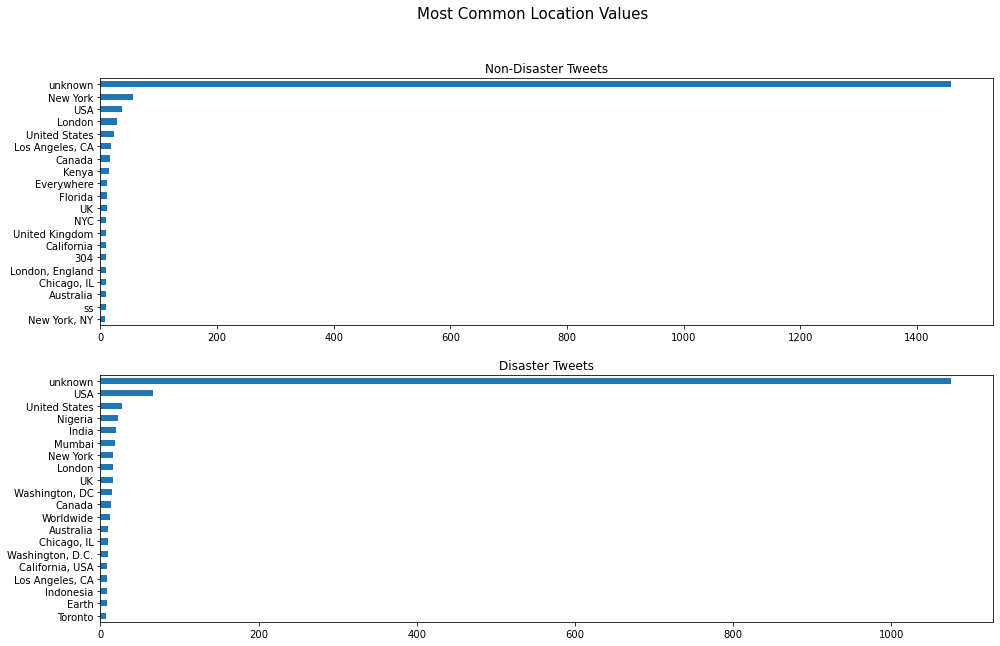

In [381]:
fig,ax = plt.subplots(2,1,figsize=(16,10))

df[df.target==0].location.value_counts(ascending=True).tail(20).plot.barh(ax=ax[0])
df[df.target==1].location.value_counts(ascending=True).tail(20).plot.barh(ax=ax[1])

ax[0].set_title('Non-Disaster Tweets')
ax[1].set_title('Disaster Tweets')

fig.suptitle('Most Common Location Values', fontsize=15)

plt.show()

The location column seems to be very disordered. I'm assuming that this information is taken from Twitter user's location cell, in which you can type anything. We can see that slightly over 1000 users haven't input a location. Apart from that, a lot of the values are different, which is to be expected.

In [382]:
# using a cvec to look at the contents of the location column

cvec_loc = CountVectorizer(lowercase=True,stop_words='english',strip_accents='unicode',ngram_range=(1,2),min_df=20)
cvec_mat = cvec_loc.fit_transform(df.location)
loc_df = pd.DataFrame(cvec_mat.toarray(),columns=cvec_loc.get_feature_names())

loc_df.sum().sort_values(ascending=False)[:20]

unknown       3641
usa            375
new            311
ca             211
new york       204
york           204
london         154
united         137
canada         129
uk             125
city           123
ny             113
california     113
san            111
england        105
washington     100
australia       91
states          87
los             87
angeles         86
dtype: int64

It's a slightly lazy approach, but I'm going to count-vectorize the location column to try to pull some information useful from it. It might be a better approach to organise this column in to categorised country/state/city columns, but part of the difficulty is that there is no order to what information is inside the column. Some have country, others have country and state and others just have city.

Removing location values with '.com' inside them

In [383]:
df.location.replace('.com','',regex=True,inplace=True)

# Text

### Countvectorisation for EDA

In [384]:
cvec = CountVectorizer(stop_words='english',ngram_range=(1,1), lowercase=False)
matr = cvec.fit_transform(df.text)
df_cvec = pd.DataFrame(matr.toarray() , columns = cvec.get_feature_names())

Having a look at the 100 most most common unigrams.

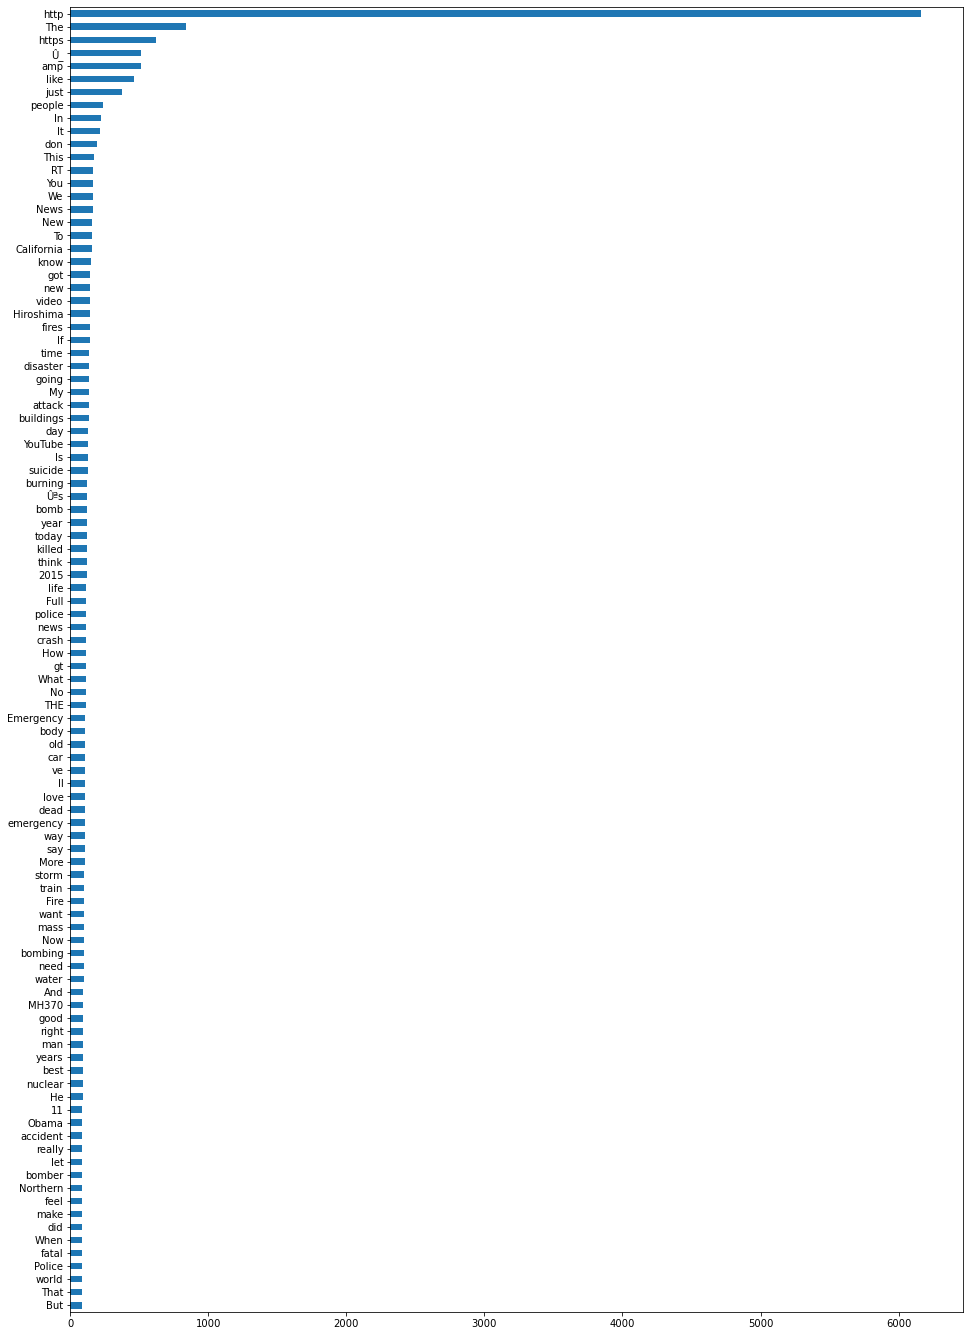

In [385]:
fig,ax=plt.subplots(figsize=(16,24))

df_cvec.sum().sort_values(ascending=True).tail(100).plot.barh(ax=ax)

plt.show()

We will be removing the http and https unigrams later down the line, for now let's remove some of the other common unigrams that aren't actual words.

In [386]:
unigrams_remove = ['\x89Û_', 'Û_', '&amp;', 'Ûªs']

for unigram in unigrams_remove:
    df['text'] = df.text.str.replace(unigram, '', regex=True)

### Cleaning tweets

In [387]:
df['text_clean'] = df.text.apply(lambda x: p.clean(x))

df.text_clean.head()

id
1                                                                    Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
4                                                                                                   Forest fire near La Ronge Sask. Canada
5    All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
6                                                                         13,000 people receive #wildfires evacuation orders in California
7                                                  Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school
Name: text_clean, dtype: object

### Creating meta-data for tweet characteristics

It would be interesting to know whether tweet meta-data (urls, emojis, mentions) have any link to the target.

In [388]:
tweet_tokenized = df.text.apply(lambda x:p.tokenize(x))

# creating a for-loop to add columns for the tweet meta-data features

for feature in ['url', 'smiley', 'mention']:
    feature_counter = []
    for tweet in tweet_tokenized:
        counter = 0
        for word in tweet.split():
            if word == "$"+feature.upper()+"$":
                counter += 1
        feature_counter.append(counter)
    df["tweet_"+feature] = feature_counter

### Meta-data for hash-tags

In [389]:
def hash_counter(x):
    counter = 0
    for word in x.split():
        if word[0] == '#' and len(word) > 1:
            counter += 1
    return counter

df['tweet_hashtag'] = df.text_clean.apply(hash_counter)

In [390]:
tweet_md = ['tweet_url', 'tweet_smiley', 'tweet_mention', 'tweet_hashtag']
target_gb = df.groupby('target').mean()

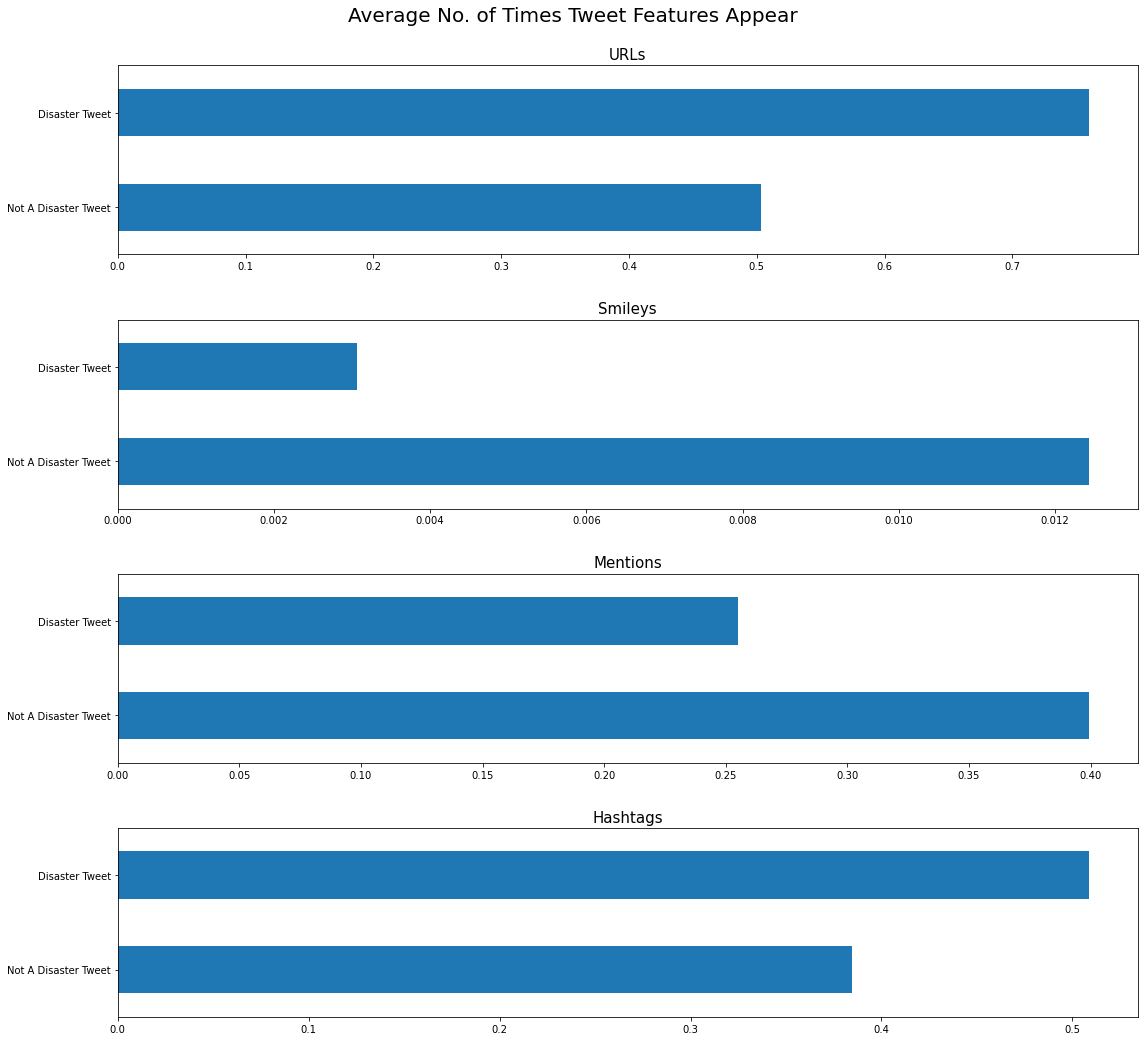

In [391]:
fig, ax = plt.subplots(4, 1, figsize = (16,14))

target_gb['tweet_url'].plot.barh(ax=ax[0])
target_gb['tweet_smiley'].plot.barh(ax=ax[1])
target_gb['tweet_mention'].plot.barh(ax=ax[2])
target_gb['tweet_hashtag'].plot.barh(ax=ax[3])

features = ['URLs', 'Smileys', 'Mentions', 'Hashtags']

for i, feature in zip(range(4), features):
    ax[i].set_title(feature, fontsize=15)
    ax[i].set_yticklabels(labels=['Not A Disaster Tweet', 'Disaster Tweet'])
    ax[i].set_ylabel(None)

fig.tight_layout(h_pad=3)
fig.suptitle('Average No. of Times Tweet Features Appear',x= 0.5, y=1.03, fontsize=20)

plt.show()

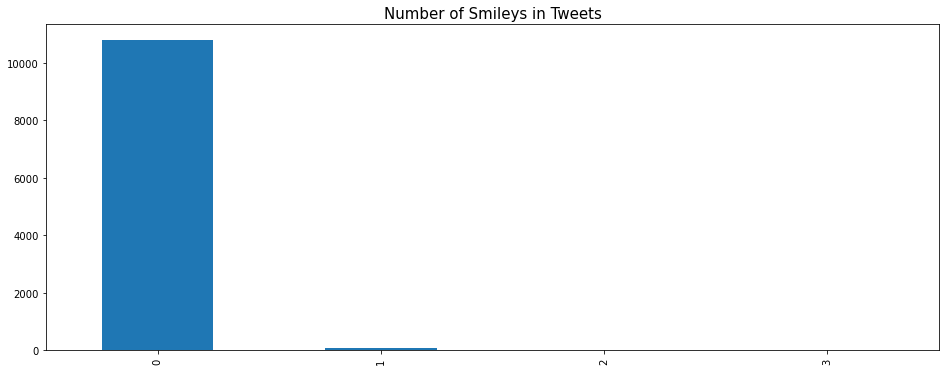

In [392]:
fig,ax = plt.subplots(figsize=(16,6))

df.tweet_smiley.value_counts().plot.bar(ax=ax)

ax.set_title('Number of Smileys in Tweets', fontsize=15)

plt.show()

Given that so few tweets contains smileys, there isn't much point including this variable as a predictor!

In [393]:
df.drop('tweet_smiley',axis=1,inplace=True)

### Text meta-data: length of tweet, number of words and average word length

In [394]:
# how many characters a tweet has

df['tweet_characters'] = df.text_clean.apply(lambda x: len(x))

In [395]:
# number of words in each tweet

def word_counter(tweet):   
    no_punct = ''.join([x for x in tweet if x not in string.punctuation])
    word_lst = no_punct.split()      
    return len(word_lst)

df['tweet_words'] = df.text_clean.apply(word_counter)

In [396]:
# average length of each word in a tweet

def ave_word_length(tweet):
    no_punct = ''.join([x for x in tweet if x not in string.punctuation])
    word_lst = no_punct.split()
    return sum(map(len, word_lst))/len(word_lst)

df['tweet_av_word_length'] = df.text_clean.apply(ave_word_length)

## Visualising the text meta-data

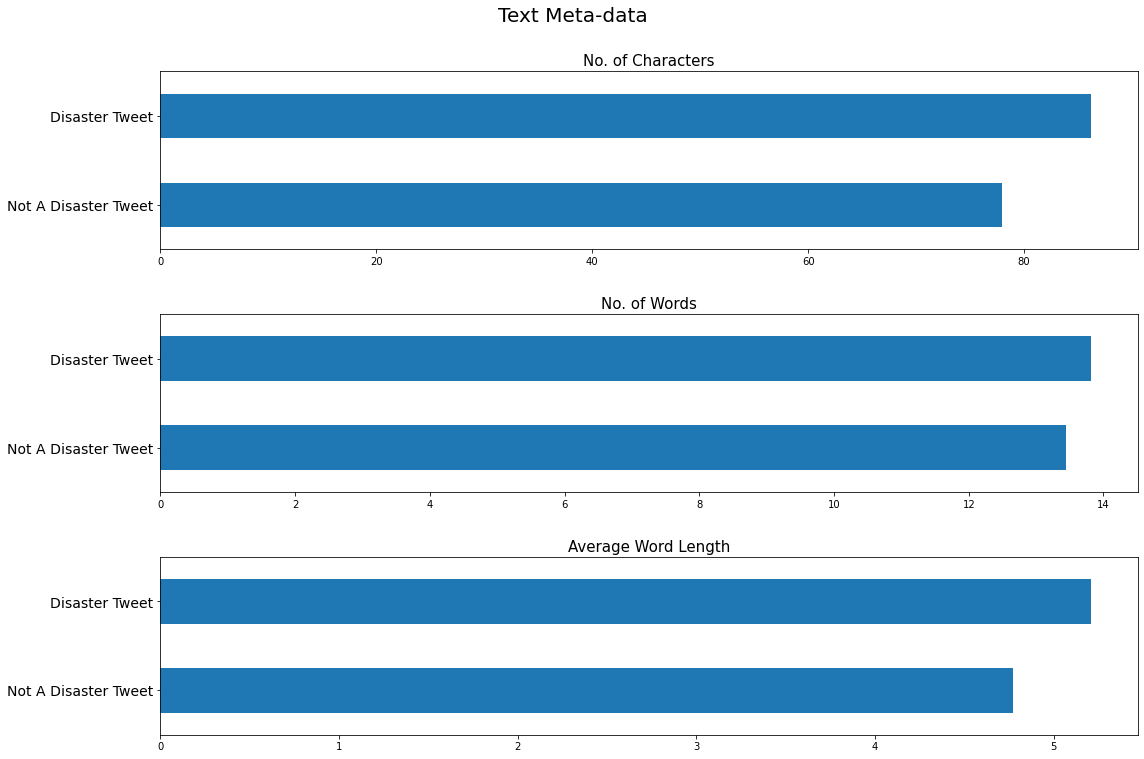

In [397]:
target_gb = df.groupby('target').mean()

fig, ax = plt.subplots(3, 1, figsize = (16,10))

target_gb['tweet_characters'].plot.barh(ax=ax[0])
target_gb['tweet_words'].plot.barh(ax=ax[1])
target_gb['tweet_av_word_length'].plot.barh(ax=ax[2])

features = ['No. of Characters', 'No. of Words', 'Average Word Length']

for i, feature in zip(range(3), features):
    ax[i].set_title(feature, fontsize=15)
    ax[i].set_yticklabels(labels=['Not A Disaster Tweet', 'Disaster Tweet'], fontsize=14)
    ax[i].set_ylabel(None)

fig.tight_layout(h_pad=3)
fig.suptitle('Text Meta-data',x= 0.5, y=1.05, fontsize=20)

plt.show()

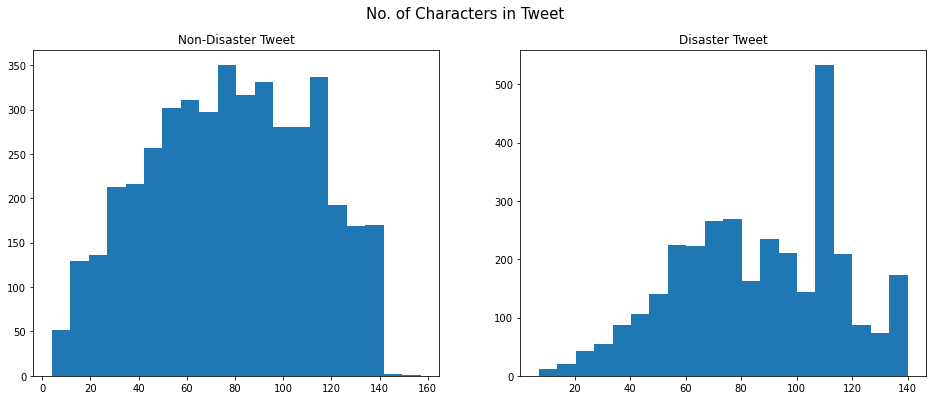

In [398]:
fig,ax = plt.subplots(1,2,figsize=(16,6))

df[df.target==0.0].tweet_characters.hist(ax=ax[0],grid=False, bins=20)
df[df.target==1.0].tweet_characters.hist(ax=ax[1],grid=False, bins=20)

ax[0].set_title('Non-Disaster Tweet')
ax[1].set_title('Disaster Tweet')
fig.suptitle('No. of Characters in Tweet', fontsize=15)

plt.show()

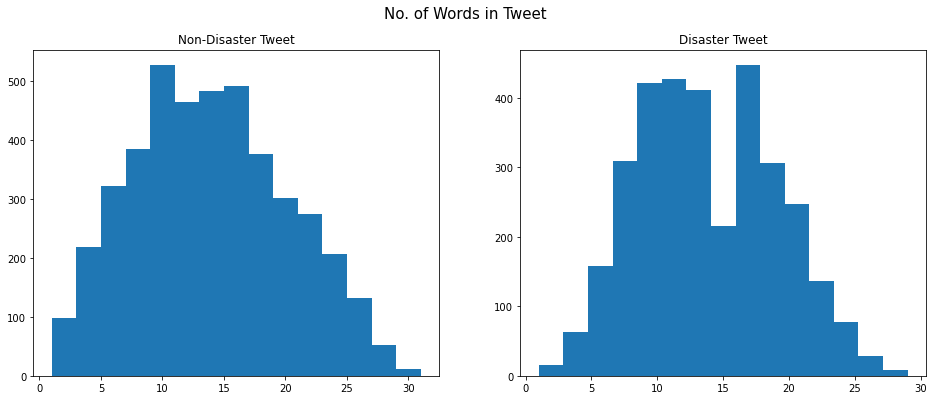

In [399]:
fig,ax = plt.subplots(1,2,figsize=(16,6))

df[df.target==0.0].tweet_words.hist(ax=ax[0],grid=False, bins=15)
df[df.target==1.0].tweet_words.hist(ax=ax[1],grid=False, bins=15)

ax[0].set_title('Non-Disaster Tweet')
ax[1].set_title('Disaster Tweet')
fig.suptitle('No. of Words in Tweet', fontsize=15)

plt.show()

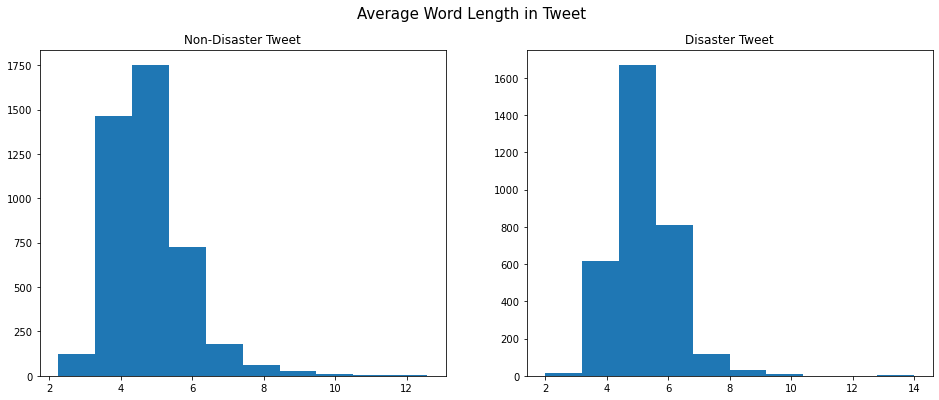

In [400]:
fig,ax = plt.subplots(1,2,figsize=(16,6))

df[df.target==0.0].tweet_av_word_length.hist(ax=ax[0],grid=False)
df[df.target==1.0].tweet_av_word_length.hist(ax=ax[1],grid=False)

ax[0].set_title('Non-Disaster Tweet')
ax[1].set_title('Disaster Tweet')
fig.suptitle('Average Word Length in Tweet', fontsize=15)

plt.show()

## Final Text Cleaning

In [401]:
# removing punctuation from tweets

for punct in string.punctuation:
    df['text_clean'] = df.text_clean.str.replace(punct,'',regex=True)

In [402]:
# removing digits

df['text_clean'] = df.text_clean.replace('\d+','',regex=True)

Expanding contractions

In [403]:
# expanding contractions

df['text_clean'] = df.text_clean.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

Tokenizing Tweets

In [404]:
# tokenizing tweets

df['text_clean'] = df.text_clean.apply(nltk.word_tokenize)

In [405]:
# changing tweets to lower case

df['text_clean'] = df.text_clean.apply(lambda x: [word.lower() for word in x])

Removing stop words

In [406]:
# downloading nltk stopwords package

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jradford/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [407]:
# instantiating the stopwords package and removing them from the text column

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

df['text_clean'] = df.text_clean.apply(lambda x: [word for word in x if word not in stop_words])

Beginning the lemmatization process

In [408]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [409]:
# part-of-speech tagging the text column

df['text_clean'] = df.text_clean.apply(nltk.tag.pos_tag)

# instantiating the nltk lemmatizer
wnl = WordNetLemmatizer()

In [410]:
# creating a function to alter the POS tagging so that it is in the right format for the NLTK lemmatizer

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
df['text_clean'] = df['text_clean'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

In [411]:
# lemmatizing the text column

df['text_clean'] = df.text_clean.apply(lambda x: ' '.join([wnl.lemmatize(word, tag) for word,tag in x]))

In [412]:
df.head()

,keyword,location,text,target,keyword_clean,text_clean,tweet_url,tweet_mention,tweet_hashtag,tweet_characters,tweet_words,tweet_av_word_length
id,,,,,,,,,,,,
1,unknown,unknown,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,unknown,deed reason earthquake may allah forgive u,0,0,1,69,13,4.307692
4,unknown,unknown,Forest fire near La Ronge Sask. Canada,1.0,unknown,forest fire near la ronge sask canada,0,0,0,38,7,4.428571
5,unknown,unknown,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,unknown,resident ask shelter place notify officer evacuation shelter place order expect,0,0,0,133,22,4.954545
6,unknown,unknown,"13,000 people receive #wildfires evacuation orders in California",1.0,unknown,people receive wildfire evacuation order california,0,0,1,64,8,6.875000
7,unknown,unknown,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,unknown,get sent photo ruby alaska smoke wildfires pour school,0,0,2,87,16,4.375000


Now we can see that the text_clean shows cleaned, lemmatized versions of the text in the dataset

### Removing columns that are no longer needed

In [413]:
df.columns

Index(['keyword', 'location', 'text', 'target', 'keyword_clean', 'text_clean',
       'tweet_url', 'tweet_mention', 'tweet_hashtag', 'tweet_characters',
       'tweet_words', 'tweet_av_word_length'],
      dtype='object')

In [414]:
# dropping the text column containing the original tweet

df.drop(['text', 'keyword'],axis=1, inplace=True)

# renaming the cleaned text column to simplify names

df.rename({'text_clean': 'text',
          'keyword_clean': 'keyword'}, axis=1, inplace=True)

# Countvectorize

### Unigrams

In [415]:
# instantiating the cvec and resulting matrix

cvec_1 = CountVectorizer(strip_accents='unicode', ngram_range=(1,1), max_df=1.0, min_df=1)
matrix = cvec_1.fit_transform(df.text)

# creating dataframes for the matrix features and target value

df_cvec_1 = pd.DataFrame(matrix.toarray(), columns = cvec_1.get_feature_names())
df_cvec_1['df_target'] = df.target

In [416]:
# number of features in matrix

len(cvec_1.get_feature_names())

15435

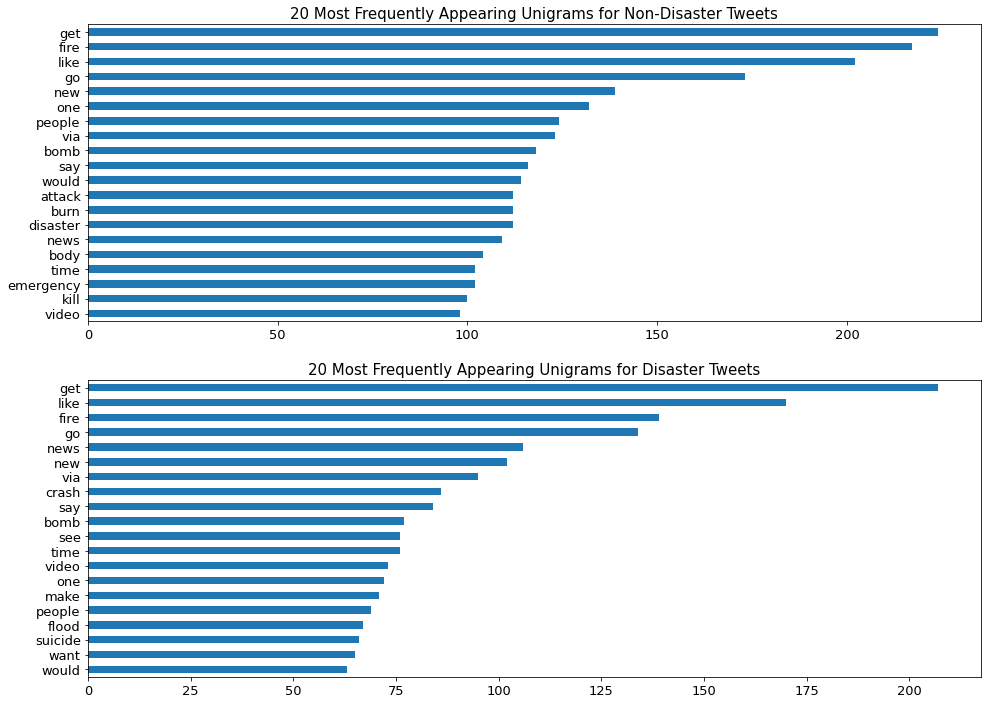

In [417]:
# instantiating groupby dataframes for both target values

top_words_0 = df_cvec_1.groupby('df_target').sum().loc[0.0].sort_values(ascending=True).tail(20)
top_words_1 = df_cvec_1.groupby('df_target').sum().loc[1.0].sort_values(ascending=True).tail(20)

# plotting the most frequently appearing ngrams

fig,ax = plt.subplots(2,1,figsize=(16,12))

top_words_0.plot.barh(ax=ax[0], fontsize=13)
top_words_1.plot.barh(ax=ax[1], fontsize=13)

ax[0].set_title('20 Most Frequently Appearing Unigrams for Non-Disaster Tweets', fontsize=15)
ax[1].set_title('20 Most Frequently Appearing Unigrams for Disaster Tweets', fontsize=15)

plt.show()

We can see that there are some expected words in the disaster tweets plot (e.g. crash, fire, bomb). Unfortunately though, a lot of these words also seem to appear in the non-disaster tweet section (e.g. fire, bomb, disaster).

### Bigrams

In [418]:
# instantiating the cvec and resulting matrix

cvec_2 = CountVectorizer(strip_accents='unicode', ngram_range=(2,2), max_df=1.0, min_df=1)
matrix_2 = cvec_2.fit_transform(df.text)

# creating dataframes for the matrix features and target value

df_cvec_2 = pd.DataFrame(matrix_2.toarray(), columns = cvec_2.get_feature_names())
df_cvec_2['df_target'] = df.target

In [419]:
# number of features in matrix

len(cvec_2.get_feature_names())

57270

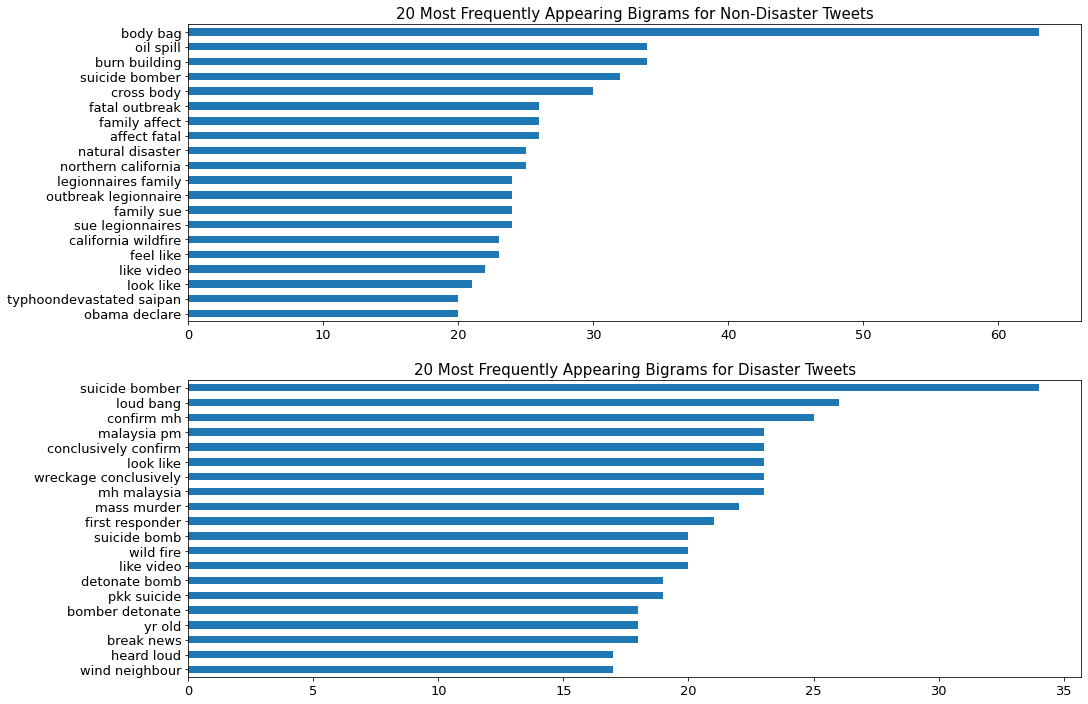

In [420]:
# instantiating the groupbp dataframes for the target values

top_bigrams_0 = df_cvec_2.groupby('df_target').sum().loc[0.0].sort_values(ascending=True).tail(20)
top_bigrams_1 = df_cvec_2.groupby('df_target').sum().loc[1.0].sort_values(ascending=True).tail(20)

# plotting the most frequently appearing ngrams

fig,ax = plt.subplots(2,1,figsize=(16,12))

top_bigrams_0.plot.barh(ax=ax[0], fontsize=13)
top_bigrams_1.plot.barh(ax=ax[1], fontsize=13)

ax[0].set_title('20 Most Frequently Appearing Bigrams for Non-Disaster Tweets', fontsize=15)
ax[1].set_title('20 Most Frequently Appearing Bigrams for Disaster Tweets', fontsize=15)

plt.show()

Unsurprisingly, we get a bit more detail from the bigrams. There are some disaster-like results for non-disaster tweets, yet they contain a bit more ambiguity (e.g. cross body, quarantine offensive, emergency service). The disaster tweets results are definitely more specifically about disasters (suicide bomber, oil spill, california wildfire). 

It's interesting, however, that 'body bag' is the most common bigram for non-disaster tweets! 

In [421]:
df[df.text.str.contains('body bag',case=False)].head(5)

,location,target,keyword,text,tweet_url,tweet_mention,tweet_hashtag,tweet_characters,tweet_words,tweet_av_word_length
id,,,,,,,,,,
1379,New York,0.0,body bag,new lady shoulder tote handbag woman cross body bag faux leather fashion purse full,2,0,0,90,15,4.933333
1380,New York,0.0,body bag,new lady shoulder tote handbag woman cross body bag faux leather fashion purse full,2,0,0,90,15,4.933333
1381,unknown,0.0,body bag,son daughter would like see go war iran come back body bag let republican know,0,0,1,138,31,3.419355
1382,"sitting on Eddie Vedders lap,",0.0,body bag,ditto way feel drink vodka ice would body bag,0,1,0,101,24,3.208333
1384,New York,0.0,body bag,louis vuitton monogram sophie limited edition clutch cross body bag full read ebay,2,0,0,87,14,5.142857


Looking at some of the tweets containing 'body bag', it seems that they are mostly referring to a fashion item.

## Trigrams

In [422]:
# instantiating the cvec and resulting matrix

cvec_3 = CountVectorizer(strip_accents='unicode', ngram_range=(3,3), max_df=1.0, min_df=1)
matrix_3 = cvec_3.fit_transform(df.text)

# creating dataframes for the matrix features and target value

df_cvec_3 = pd.DataFrame(matrix_3.toarray(), columns = cvec_3.get_feature_names())
df_cvec_3['df_target'] = df.target

In [423]:
len(cvec_3.get_feature_names())

55413

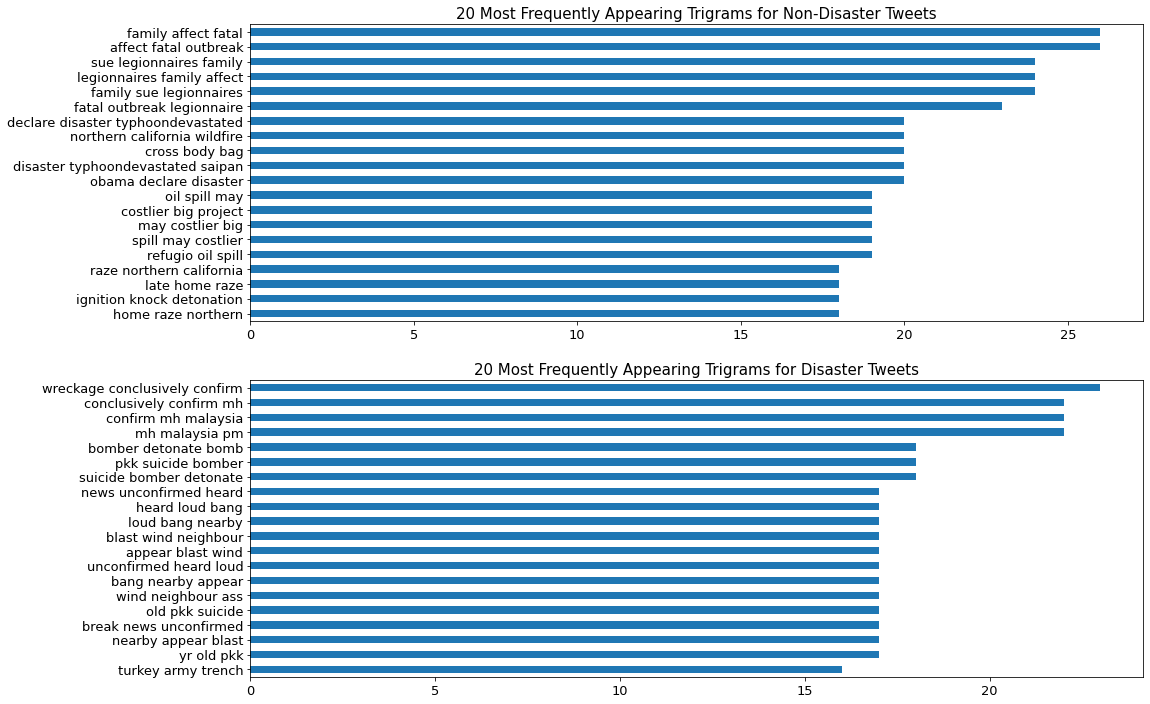

In [424]:
# instantiating the groupbp dataframes for the target values

top_trigrams_0 = df_cvec_3.groupby('df_target').sum().loc[0.0].sort_values(ascending=True).tail(20)
top_trigrams_1 = df_cvec_3.groupby('df_target').sum().loc[1.0].sort_values(ascending=True).tail(20)

# plotting the most frequently appearing ngrams

fig,ax = plt.subplots(2,1,figsize=(16,12))

top_trigrams_0.plot.barh(ax=ax[0], fontsize=13)
top_trigrams_1.plot.barh(ax=ax[1], fontsize=13)

ax[0].set_title('20 Most Frequently Appearing Trigrams for Non-Disaster Tweets', fontsize=15)
ax[1].set_title('20 Most Frequently Appearing Trigrams for Disaster Tweets', fontsize=15)

plt.show()

# Splitting the dataset

In [425]:
train = df[df.target.notna()]
test = df[df.target.isna()]

In [426]:
train['target'] = train.target.astype('int')

<ipython-input-426-d5a000598bff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['target'] = train.target.astype('int')


In [427]:
test.drop('target',axis=1,inplace=True)

/Users/jradford/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [433]:
# joblib.dump(train, 'jlib_files/train_df')

['jlib_files/train_df']

In [434]:
# joblib.dump(test, 'jlib_files/test_df')

['jlib_files/test_df']

In [435]:
train = joblib.load('jlib_files/train_df')

In [436]:
test = joblib.load('jlib_files/test_df')

In [437]:
X = train.copy()
y = X.pop('target')

In [438]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1, shuffle=True, stratify=y)

# Column Transfer/Pipeline/Modelling

## Logistic Regression

In [439]:
one_hot = OneHotEncoder(drop=None,sparse=True, handle_unknown='ignore')
cvec_loc = CountVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(1,1), min_df=25)
cvec_text = CountVectorizer(strip_accents='unicode', ngram_range=(1,1), min_df=20)

col_trans = ColumnTransformer(
[('keyword', one_hot, ['keyword']),
 ('cvec_loc', cvec_loc, 'location'),
 ('cvec_text', cvec_text, 'text')],
    remainder='passthrough')

scaler = StandardScaler(with_mean=False, with_std=True)

log_reg = LogisticRegression(n_jobs=-2)

log_reg_pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('log_reg', log_reg)])

In [440]:
log_reg_pipe.fit(X_train,y_train)

print("Training Score: {}".format(log_reg_pipe.score(X_train,y_train)))
print("Test Score: {}".format(log_reg_pipe.score(X_test,y_test)))

cv_scores = cross_val_score(log_reg_pipe,X_train,y_train,scoring='f1',cv=5,n_jobs=-2,verbose=-1,)
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.8400656814449918
Test Score: 0.7695338148391333


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Scores: [0.7009901  0.70729271 0.69300912 0.75528701 0.69367589]
CV Mean Score: 0.7100509646470299


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    0.8s finished


In [444]:
test_predictions = log_reg_pipe.predict(X_test)

In [445]:
confusion_matrix(y_test,test_predictions)

array([[719, 150],
       [201, 453]])

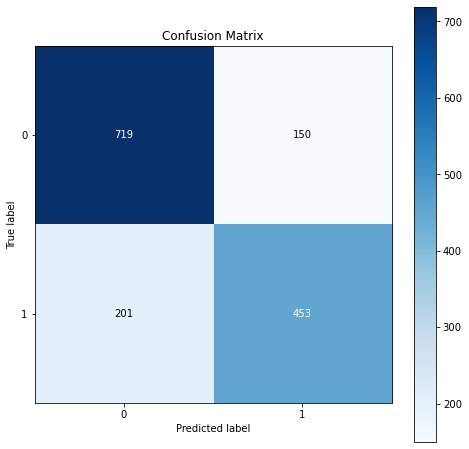

In [450]:
skplt.metrics.plot_confusion_matrix(y_test,test_predictions,figsize=(8,8))
plt.show()

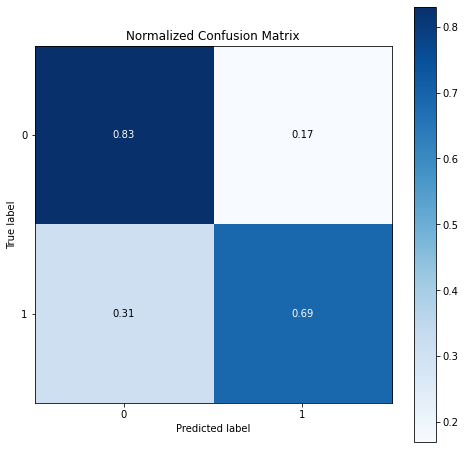

In [451]:
skplt.metrics.plot_confusion_matrix(y_test,test_predictions,figsize=(8,8),normalize=True)
plt.show()

In [452]:
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       869
           1       0.75      0.69      0.72       654

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



In [453]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", len(log_reg_pipe.classes_)))

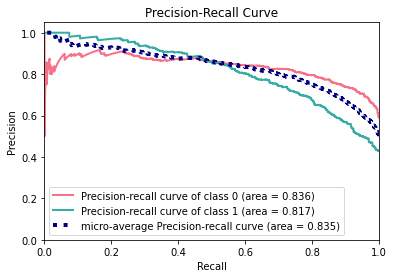

In [454]:
skplt.metrics.plot_precision_recall(y_test, log_reg_pipe.predict_proba(X_test),cmap=cmap)
plt.show()

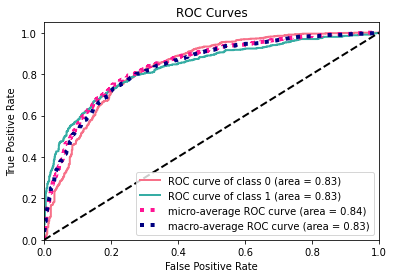

In [455]:
skplt.metrics.plot_roc(y_test, log_reg_pipe.predict_proba(X_test), cmap=cmap)
plt.show()

In [458]:
# creating a matrix to view which predictors were the most useful for the model

col_trans_mat = pd.DataFrame(col_trans.transform(X_train).toarray(),columns=col_trans.get_feature_names())

log_reg_df = pd.DataFrame({'appearances': col_trans_mat.sum(),'coef_value':log_reg_pipe.named_steps['log_reg'].coef_.reshape(-1)},
                          index=log_reg_pipe.named_steps['col_trans'].get_feature_names())

log_reg_df['abs_coef'] = log_reg_df.coef_value.abs()
log_reg_df.drop(['tweet_words','tweet_characters', 'tweet_url'],inplace=True)

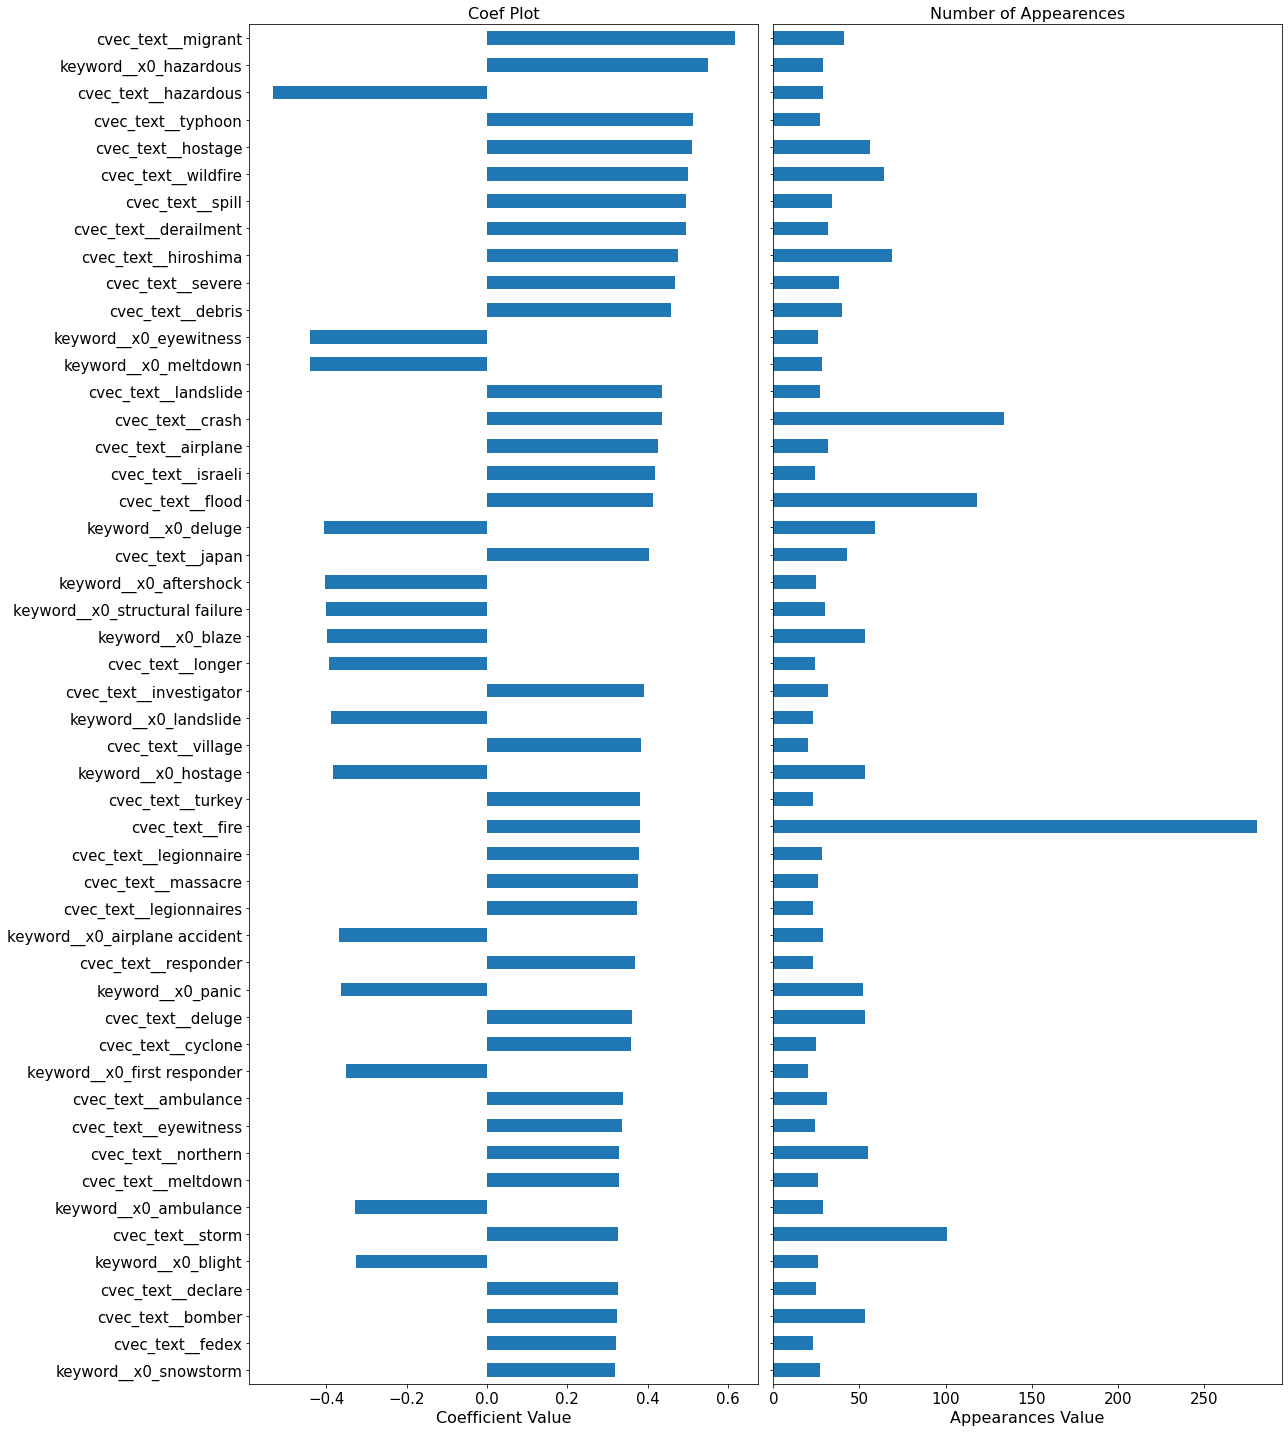

In [459]:
fig,ax = plt.subplots(1,2,figsize=(18,20),sharey=True)

log_reg_df.sort_values('abs_coef',ascending=True)[['coef_value']].iloc[-50:].plot.barh(ax=ax[0],fontsize=15,legend=False)
log_reg_df.sort_values('abs_coef',ascending=True)[['appearances']].iloc[-50:].plot.barh(ax=ax[1],fontsize=15,legend=False)


ax[0].set_title('Coef Plot', fontsize=(16))
ax[0].set_xlabel('Coefficient Value', fontsize=(16))

ax[1].set_title('Number of Appearences', fontsize=(16))
ax[1].set_xlabel('Appearances Value', fontsize=(16))

fig.tight_layout()

plt.show()

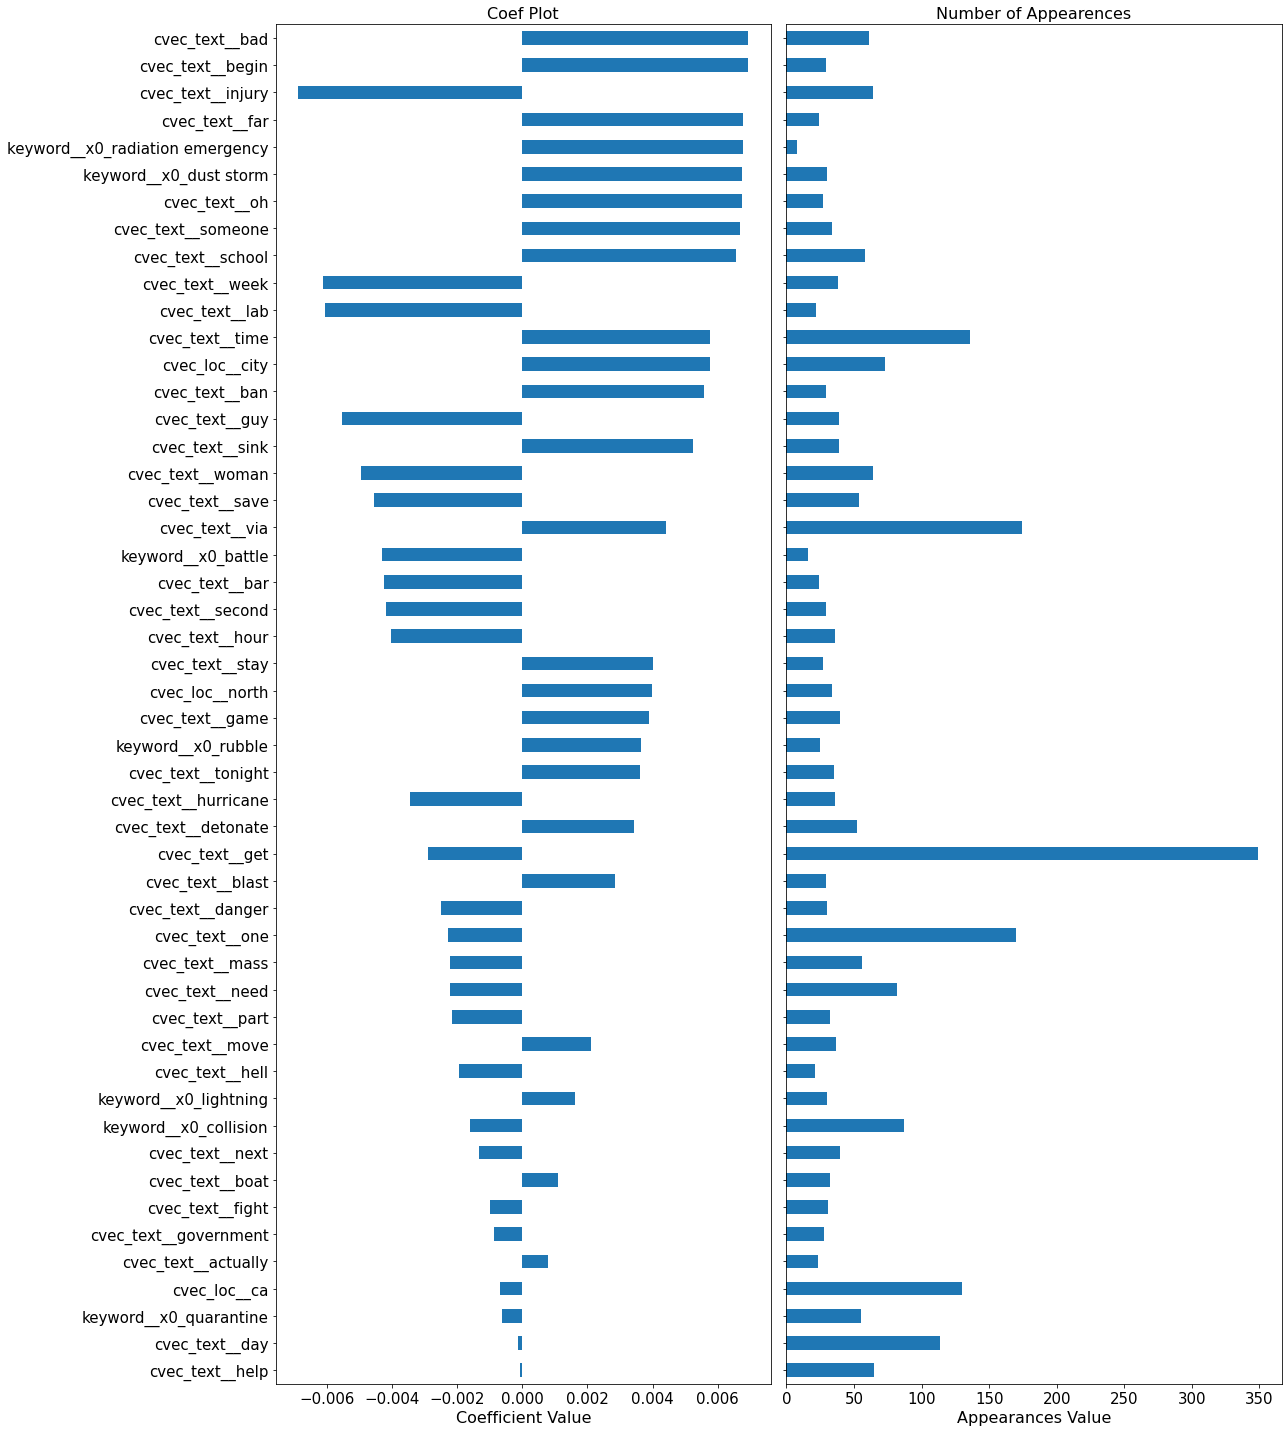

In [460]:
fig,ax = plt.subplots(1,2,figsize=(18,20),sharey=True)

log_reg_df.sort_values('abs_coef',ascending=True)[['coef_value']].iloc[:50].plot.barh(ax=ax[0],fontsize=15,legend=False)
log_reg_df.sort_values('abs_coef',ascending=True)[['appearances']].iloc[:50].plot.barh(ax=ax[1],fontsize=15,legend=False)


ax[0].set_title('Coef Plot', fontsize=(16))
ax[0].set_xlabel('Coefficient Value', fontsize=(16))

ax[1].set_title('Number of Appearences', fontsize=(16))
ax[1].set_xlabel('Appearances Value', fontsize=(16))

fig.tight_layout()

plt.show()

## Support Vector Machine

Countvectorizer

In [461]:
one_hot = OneHotEncoder(drop=None,sparse=True, handle_unknown='ignore')
cvec_loc = CountVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(1,1), min_df=25)
cvec_text = CountVectorizer(strip_accents='unicode', ngram_range=(1,1), min_df=20)

col_trans = ColumnTransformer(
[('keyword', one_hot, ['keyword']),
 ('cvec_loc', cvec_loc, 'location'),
 ('cvec_text', cvec_text, 'text')],
    remainder='passthrough')

scaler = StandardScaler(with_mean=False, with_std=True)

svc = SVC(probability=True,random_state=1)

svc_pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('svc', svc)])

In [462]:
svc_pipe.fit(X_train,y_train)

print("Training Score: {}".format(svc_pipe.score(X_train,y_train)))
print("Test Score: {}".format(svc_pipe.score(X_test,y_test)))

cv_scores = cross_val_score(svc_pipe,X_train,y_train,scoring='f1',cv=5,n_jobs=-2,verbose=-1,)
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.896551724137931
Test Score: 0.7997373604727511


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Scores: [0.7278415  0.71957672 0.71848739 0.74946921 0.71881607]
CV Mean Score: 0.7268381796378952


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    7.9s finished


Tf-idf

In [469]:
one_hot = OneHotEncoder(drop=None,sparse=True, handle_unknown='ignore')
cvec_loc = CountVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(1,1), min_df=25)
tfidf_text = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,1), min_df=20)

col_trans = ColumnTransformer(
[('keyword', one_hot, ['keyword']),
 ('cvec_loc', cvec_loc, 'location'),
 ('tfidf_text', tfidf_text, 'text')],
    remainder='passthrough')

scaler = StandardScaler(with_mean=False, with_std=True)

svc = SVC(probability=True,random_state=1)

svc_pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('svc', svc)])

In [470]:
svc_pipe.fit(X_train,y_train)

print("Training Score: {}".format(svc_pipe.score(X_train,y_train)))
print("Test Score: {}".format(svc_pipe.score(X_test,y_test)))

cv_scores = cross_val_score(svc_pipe,X_train,y_train,scoring='f1',cv=5,n_jobs=-2,verbose=-1,)
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.9019704433497537
Test Score: 0.7964543663821405


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Scores: [0.72049689 0.71413613 0.72033898 0.75664187 0.71865121]
CV Mean Score: 0.7260530170535647


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    6.4s finished


## Decision Tree Classifier

In [463]:
one_hot = OneHotEncoder(drop=None,sparse=True, handle_unknown='ignore')
cvec_loc = CountVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(1,1), min_df=25)
cvec_text = CountVectorizer(strip_accents='unicode', ngram_range=(1,1), min_df=20)

col_trans = ColumnTransformer(
[('keyword', one_hot, ['keyword']),
 ('cvec_loc', cvec_loc, 'location'),
 ('cvec_text', cvec_text, 'text')],
    remainder='passthrough')

scaler = StandardScaler(with_mean=False, with_std=True)

decisiontree = DecisionTreeClassifier(random_state=1)

decisiontree_pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('decisiontree', decisiontree)])

In [464]:
decisiontree_pipe.fit(X_train,y_train)

print("Training Score: {}".format(decisiontree_pipe.score(X_train,y_train)))
print("Test Score: {}".format(decisiontree_pipe.score(X_test,y_test)))

cv_scores = cross_val_score(decisiontree_pipe,X_train,y_train,scoring='f1',cv=5,n_jobs=-2,verbose=-1,)
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.9924466338259442
Test Score: 0.6979645436638214


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Scores: [0.63085938 0.63063063 0.63405088 0.60392157 0.63697967]
CV Mean Score: 0.6272884251491746


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    1.0s finished


## Random Forest Classifier

In [465]:
one_hot = OneHotEncoder(drop=None,sparse=True, handle_unknown='ignore')
cvec_loc = CountVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(1,1), min_df=25)
cvec_text = CountVectorizer(strip_accents='unicode', ngram_range=(1,1), min_df=20)

col_trans = ColumnTransformer(
[('keyword', one_hot, ['keyword']),
 ('cvec_loc', cvec_loc, 'location'),
 ('cvec_text', cvec_text, 'text')],
    remainder='passthrough')

scaler = StandardScaler(with_mean=False, with_std=True)

randomforest = RandomForestClassifier(n_estimators=200,n_jobs=-2,random_state=1)

randomforest_pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('randomforest', randomforest)])

In [466]:
randomforest_pipe.fit(X_train,y_train)

print("Training Score: {}".format(randomforest_pipe.score(X_train,y_train)))
print("Test Score: {}".format(randomforest_pipe.score(X_test,y_test)))

cv_scores = cross_val_score(randomforest_pipe,X_train,y_train,scoring='f1',cv=5,n_jobs=-2,verbose=-1,)
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.9924466338259442
Test Score: 0.7787261982928431


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Scores: [0.69148936 0.68695652 0.70425532 0.72497366 0.69255663]
CV Mean Score: 0.7000462986749814


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    2.6s finished


## SVM - Grid Search

Countvectorizer

In [136]:
one_hot = OneHotEncoder(drop=None,sparse=True, handle_unknown='ignore')
cvec_loc = CountVectorizer(strip_accents='unicode', stop_words='english',ngram_range=(1,1),min_df=15)
cvec_text = CountVectorizer(strip_accents='unicode')

col_trans = ColumnTransformer(
[('keyword', one_hot, ['keyword']),
 ('cvec_loc', cvec_loc, 'location'),
 ('cvec_text', cvec_text, 'text')],
    remainder='passthrough')

scaler = StandardScaler(with_mean=False, with_std=True)

svc = SVC(kernel='rbf',probability=True,random_state=1)

svc_pipe = Pipeline(steps = [('col_trans', col_trans),
                             ('scaler', scaler),
                             ('svc', svc)])

params_svc_rbf = {'svc__C': np.logspace(-1, 1, 15),
                  'svc__gamma': ['scale','auto'],
                  'svc__class_weight': [None, 'balanced'],
                 'col_trans__cvec_text__min_df': [1, 10, 15, 20, 25],
                 'col_trans__cvec_text__ngram_range': [(1,1),(1,2),(1,3)]}

gs_svc = GridSearchCV(svc_pipe, params_svc_rbf, scoring='f1', n_jobs=-2, cv=5, verbose=2)

In [137]:
gs_svc.fit(X_train,y_train)

print("Training Score: {}".format(gs_svc.score(X_train,y_train)))
print("Test Score: {}".format(gs_svc.score(X_test,y_test)))
print("CV Mean Score: {}".format(gs_svc.best_score_))
print("Best Model Parameters: {}".format(gs_svc.best_params_)) 

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


/Users/jradford/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training Score: 0.8716444845477103
Test Score: 0.7444089456869011
CV Mean Score: 0.7489303887703864
Best Model Parameters: {'col_trans__cvec_text__min_df': 15, 'col_trans__cvec_text__ngram_range': (1, 3), 'svc__C': 0.7196856730011519, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}


In [138]:
# joblib.dump(gs_svc.best_estimator_,'jlib_files/gs_svc_best_estimator_cvec')

['jlib_files/gs_svc_best_estimator_cvec']

Tf-idf

In [139]:
one_hot = OneHotEncoder(drop=None,sparse=True, handle_unknown='ignore')
cvec_loc = CountVectorizer(strip_accents='unicode', stop_words='english',ngram_range=(1,1),min_df=10)
tfidf_text = TfidfVectorizer(strip_accents='unicode')

col_trans = ColumnTransformer(
[('keyword', one_hot, ['keyword']),
 ('cvec_loc', cvec_loc, 'location'),
 ('tfidf_text', tfidf_text, 'text')],
    remainder='passthrough')

scaler = StandardScaler(with_mean=False, with_std=True)

svc = SVC(kernel='rbf',probability=True,random_state=1)

svc_pipe = Pipeline(steps = [('col_trans', col_trans),
                             ('scaler', scaler),
                             ('svc', svc)])

params_svc_rbf = {'svc__C': np.logspace(-1, 1, 15),
                  'svc__gamma': ['scale','auto'],
                  'svc__class_weight': [None, 'balanced'],
                 'col_trans__tfidf_text__min_df': [1, 10, 15, 20, 25],
                 'col_trans__tfidf_text__ngram_range': [(1,1),(1,2),(1,3)]}

gs_svc = GridSearchCV(svc_pipe, params_svc_rbf, scoring='f1', n_jobs=-2, cv=5, verbose=2)

In [140]:
gs_svc.fit(X_train,y_train)

print("Training Score: {}".format(gs_svc.score(X_train,y_train)))
print("Test Score: {}".format(gs_svc.score(X_test,y_test)))
print("CV Mean Score: {}".format(gs_svc.best_score_))
print("Best Model Parameters: {}".format(gs_svc.best_params_)) 

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


/Users/jradford/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training Score: 0.9057193923145666
Test Score: 0.7343503419253025
CV Mean Score: 0.7463142829767752
Best Model Parameters: {'col_trans__tfidf_text__min_df': 15, 'col_trans__tfidf_text__ngram_range': (1, 1), 'svc__C': 1.0, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}


In [141]:
# joblib.dump(gs_svc.best_estimator_,'jlib_files/gs_svc_best_estimator_tfidf_2')

['jlib_files/gs_svc_best_estimator_tfidf_2']

In [390]:
svc_pipe = joblib.load('jlib_files/gs_svc_best_estimator_cvec')

In [391]:
svc_pipe

Pipeline(steps=[('col_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('keyword',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['keyword']),
                                                 ('cvec_loc',
                                                  CountVectorizer(min_df=15,
                                                                  stop_words='english',
                                                                  strip_accents='unicode'),
                                                  'location'),
                                                 ('cvec_text',
                                                  CountVectorizer(min_df=15,
                                                                  ngram_range=(1,
                                                                               3),
        

In [392]:
svc_pipe.fit(X_train,y_train)

print("Training Score: {}".format(svc_pipe.score(X_train,y_train)))
print("Test Score: {}".format(svc_pipe.score(X_test,y_test)))

cv_scores = cross_val_score(svc_pipe,X_train,y_train,scoring='f1',cv=5,n_jobs=-2,verbose=1,)
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.8932257459185589
Test Score: 0.7898423817863398


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


CV Scores: [0.73696145 0.74305556 0.75475924 0.7674685  0.7424072 ]
CV Mean Score: 0.7489303887703864


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    7.1s finished


In [393]:
test_predictions = svc_pipe.predict(X_test)

In [395]:
confusion_matrix(y_test,test_predictions)

array([[1105,  198],
       [ 282,  699]])

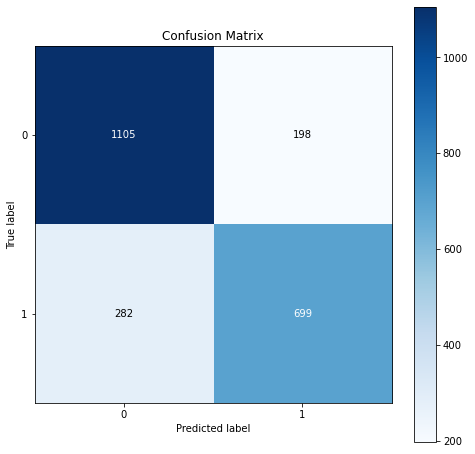

In [396]:
skplt.metrics.plot_confusion_matrix(y_test,test_predictions,figsize=(8,8))
plt.show()

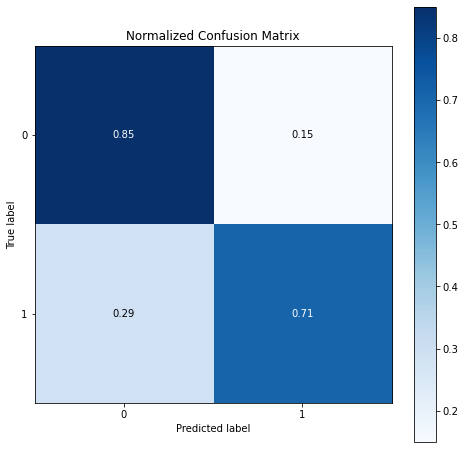

In [397]:
skplt.metrics.plot_confusion_matrix(y_test,test_predictions,figsize=(8,8),normalize=True)
plt.show()

In [398]:
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1303
           1       0.78      0.71      0.74       981

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284



In [399]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", len(svc_pipe.classes_)))

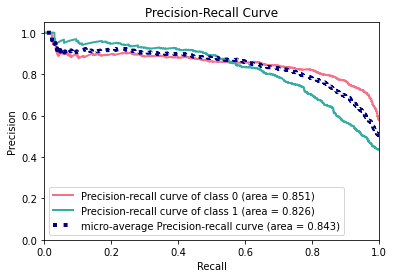

In [400]:
skplt.metrics.plot_precision_recall(y_test, svc_pipe.predict_proba(X_test),cmap=cmap)
plt.show()

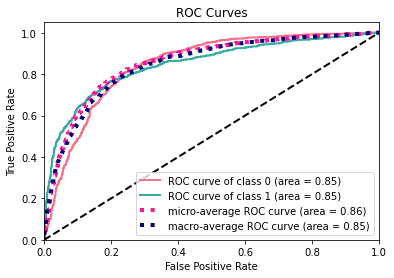

In [401]:
skplt.metrics.plot_roc(y_test, svc_pipe.predict_proba(X_test), cmap=cmap)
plt.show()

In [424]:
df_test_pred = X_test.copy()
df_test_pred['target'] = y_test.copy()
df_test_pred['prediction'] = test_predictions

In [426]:
df_fp_1 = df_test_pred[(df_test_pred.target==1)&(df_test_pred.prediction==0)]